In [1]:
import multi_axis as ma
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from scipy import constants                     # For scientific constants
import matplotlib.patches as patches
import tomopy
%config Completer.use_jedi = False

Compilation successful


In [2]:
def generate_phase_data(MX,MY,MZ,angles,mesh_params=None,n_pad=500):
    """ Returns phase projections for given M and angles
    in order [x, i_tilt, y] """
    # Initialise parameters
    phase_projs = []
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(MX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    
    # Loop through projection angles
    for i in range(len(angles)):
        ax,ay,az = angles[i]
        #rotate M
        MXr,MYr,MZr = rotate_magnetisation(MX,MY,MZ,ax,ay,az)
        #calculate phase
        phase = ma.calculate_phase_M_2D(MXr,MYr,MZr,mesh_params=mesh_params,n_pad=n_pad)
        phase = np.flipud(phase.T)

        phase_projs.append(phase)            
    
#    # Prepare projections for reconstruction
#    raw_data = np.array(M_projs)
#     raw_data = raw_data -  raw_data.min()
#     raw_data = raw_data/raw_data.max()
    phase_projs = np.transpose(phase_projs,axes=[1,0,2]) # reshape so proj is middle column
        
    return np.array(phase_projs)

def rotate_magnetisation(U,V,W,ax=0,ay=0,az=0):
    """ 
    Takes 3D gridded magnetisation values as input
    and returns them after an intrinsic rotation ax,ay,az 
    about the x,y,z axes (given in degrees) 
    (Uses convention of rotating about z, then y, then x)
    """
    # Rotate the gridded locations of M values
    Ub = ma.rotate_bulk(U,ax,ay,az)
    Vb = ma.rotate_bulk(V,ax,ay,az)
    Wb = ma.rotate_bulk(W,ax,ay,az)
    
    shape = np.shape(Ub)
    
    # Convert gridded values to vectors
    coor_flat = grid_to_coor(Ub,Vb,Wb)
    
    # Rotate vectors
    coor_flat_r = rotate_vector(coor_flat,ax,ay,az)
    
    # Convert vectors back to gridded values
    Ur,Vr,Wr = coor_to_grid(coor_flat_r,shape=shape)
    
    # Set small values to 0
    # (In theory the magnitude of M in each cell should be Ms,
    #  so we can set magnitude lower than this to zero -
    #  typically python rounding errors lead to very small values,
    #  which it is useful to exclude here)
    mag_max = (np.max(U)**2+np.max(V)**2+np.max(W)**2)**0.5
    mag = (Ur**2+Vr**2+Wr**2)**.5
#     for M in [Ur,Vr,Wr]:
#         M[abs(M)<1e-5*mag_max] = 0
#         M[mag<.6*mag_max] = 0
    
    return Ur,Vr,Wr

def grid_to_coor(U,V,W):
    """ Convert gridded 3D data (3,n,n,n) into coordinates (n^3, 3) """
    coor_flat = []
    nx = np.shape(U)[0]
    ny = np.shape(U)[1]
    nz = np.shape(U)[2]
    for ix in range(nx):
        for iy in range(ny):
            for iz in range(nz):
                x = U[ix,iy,iz]
                y = V[ix,iy,iz]
                z = W[ix,iy,iz]
                coor_flat.append([x,y,z])
                
    return coor_flat

def coor_to_grid(coor_flat,shape=None):
    """ Convert coordinates (n^3, 3) into gridded 3D data (3,n,n,n) """
    if shape == None:
        n = int(np.round(np.shape(coor_flat)[0]**(1/3)))
        shape = (n,n,n)
    nx,ny,nz = shape
    
    x = np.take(coor_flat,0,axis=1)
    y = np.take(coor_flat,1,axis=1)
    z = np.take(coor_flat,2,axis=1)
    U = x.reshape((nx,ny,nz))
    V = y.reshape((nx,ny,nz))
    W = z.reshape((nx,ny,nz))

    return U, V, W

def rotate_vector(coor_flat,ax,ay,az):
    """ Rotates vectors by specified angles ax,ay,az 
    about the x,y,z axes (given in degrees) """
    
    # Get rotation matrix
    mrot = ma.rotation_matrix(ax,ay,az)    

    coor_flat_r = np.zeros_like(coor_flat)
    
    # Apply rotation matrix to each M vector
    for i,M in enumerate(coor_flat):
        coor_flat_r[i] = mrot.dot(M)
    
    return coor_flat_r

<class 'matplotlib.axes._subplots.AxesSubplot'>
[  5.00000000e-08   5.00000000e-08]


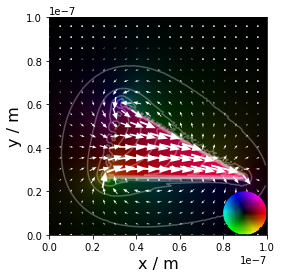

In [15]:
# MX,MY,MZ,mesh_params=ma.Magnetic_Phantom.tri_pris()
# phase = ma.calculate_phase_M_2D(MX,MY,MZ,mesh_params=mesh_params)
# bmag,bx,by = ma.calculate_B_from_phase(phase,mesh_params=mesh_params)
fig,ax=plt.subplots()
ma.plot_2d_B(bx,by,mesh_params=mesh_params,B_contour=True,ax=ax)
ma.plot_colorwheel(clip=1e-8,shape=np.shape(bx)[0]+100,rad=0.1,mesh_params=mesh_params,shift_centre=(80,-80),ax=ax)

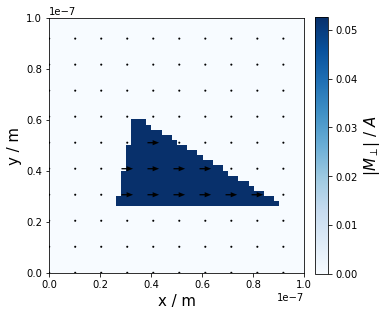

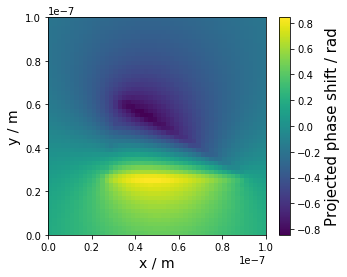

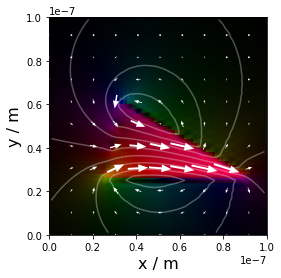

In [3]:
# M
MX,MY,MZ,mesh_params=ma.Magnetic_Phantom.tri_pris(bbox_length_px=50)
# phase proj
phase = ma.calculate_phase_M_2D(MX,MY,MZ,mesh_params=mesh_params)
# b proj
bmag,bx,by = ma.calculate_B_from_phase(phase,mesh_params=mesh_params)
# A 3d
AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=100)
# B 3d
BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params)

mx,my=ma.project_along_z(MX,mesh_params=mesh_params),ma.project_along_z(MY,mesh_params=mesh_params)
ma.plot_2d_mag(mx,my,mesh_params=mesh_params,s=5)
ma.plot_phase_proj(phase,mesh_params=mesh_params)
ma.plot_2d_B(bx,by,mesh_params=mesh_params,phase=phase,B_contour=False)

In [3]:
# Generate phase projection data
MX,MY,MZ,mesh_params=ma.Magnetic_Phantom.tri_pris(bbox_length_px=30)
angles_x = ma.generate_angles(mode='x',n_tilt=40,alpha=90)
angles_y = ma.generate_angles(mode='y',n_tilt=40,beta=90,tilt2='beta')
phases_x = generate_phase_data(MX,MY,MZ,angles_x,mesh_params=mesh_params,n_pad=50)
phases_y = generate_phase_data(MX,MY,MZ,angles_y,mesh_params=mesh_params,n_pad=50)

In [61]:
# A 3d
AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=50)
# B 3d
BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params2)

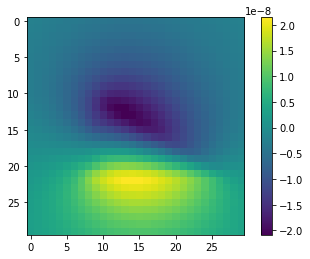

In [5]:
n=30
plt.imshow(-np.flipud(AZ[:,:,15+n].T)[n:-n,n:-n])
plt.colorbar()

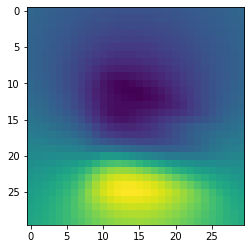

In [82]:
#ma.plot_phase_proj(phases_x[:,1,:],mesh_params=mesh_params)
plt.imshow(phases_x[:,30,:])
#ma.plot_phase_proj(raw_data[:,6,:])

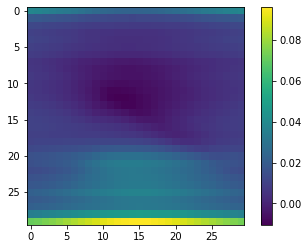

In [51]:
plt.imshow(np.flipud(rx[:,:,15].T))
plt.colorbar()

In [103]:
import open3d as o3d
import matplotlib
s=3 # set number of voxels to skip (increase speed)

# Convert grid to point cloud
points = np.transpose(np.where(rx[::s,::s,::s]>0.01))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

cmap = matplotlib.cm.get_cmap('viridis')
shape = np.shape(points)
cols = np.zeros_like(points,dtype=np.float16)
for i,p in enumerate(points):
    p = np.array(p)*s # account for skipping
    val = (rx[p[0],p[1],p[2]]-np.min(rx))/np.max(rx)

    c = cmap(val)
    cols[i,0] = c[0]
    cols[i,1] = c[1]
    cols[i,2] = c[2]
pcd.colors = o3d.utility.Vector3dVector(cols)

o3d.visualization.draw_geometries([pcd])

In [104]:
px = phases_x#-np.min(phases_x)
# px=px/np.max(px)
# plt.imshow(px[:,20,:])
# plt.colorbar()

In [5]:
vecs = ma.generate_vectors(angles_x)
recon_x = ma.generate_reconstruction(phases_x,vecs, algorithm = 'SIRT3D_CUDA', niter=40, weight = 0.001,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

vecs = ma.generate_vectors(angles_y)
recon_y = ma.generate_reconstruction(phases_y,vecs, algorithm = 'SIRT3D_CUDA', niter=40, weight = 0.01,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

In [6]:
rx = np.transpose(recon_x,axes=(2,1,0))[:,::-1,:]
ry = np.transpose(recon_y,axes=(2,1,0))[:,::-1,:]
# rx = ma.reorient_reconstruction(recon_x)
# ry = ma.reorient_reconstruction(recon_y)

In [27]:
def plot_phase_proj(phase,mesh_params=None,ax=None):
    """ Plots the projected phase shift in rads """
    if mesh_params == None:
            p1 = (0,0,0)
            sx,sy = np.shape(phase)
            p2 = (sx,sy,sx)
            n = p2
    else:
        p1,p2,n = mesh_params
        
    if ax == None:
        fig,ax = plt.subplots()
    f=plt.gcf()
        

    im=ax.imshow(phase.T,extent=[p1[0],p2[0],p1[1],p2[1]],origin='lower')
    cbar = f.colorbar(im,fraction=0.046, pad=0.04,ax=ax)
    cbar.set_label('Projected phase shift / rad', rotation=-270,fontsize=15)
    ax.set_xlabel('x / m',fontsize=14)
    ax.set_ylabel('y / m',fontsize=14)
    
    if ax == None:
        plt.show()

Text(0.5, 1, '|Difference|')

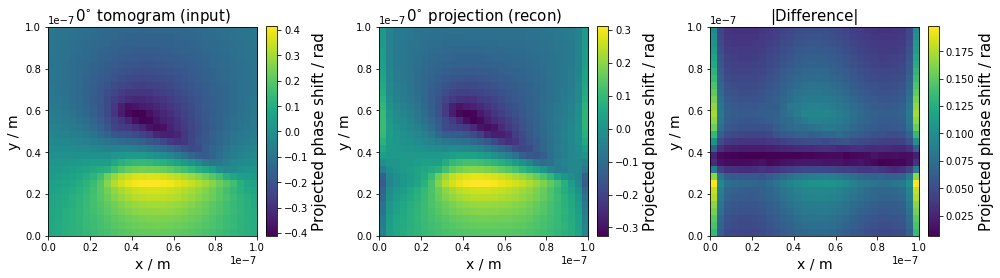

In [40]:
f,ax = plt.subplots(ncols=3,figsize=(14,9))
plot_phase_proj(np.flipud(phases_y[:,20,:]).T,mesh_params=mesh_params,ax=ax[0])
plot_phase_proj(np.sum(ry,axis=2),mesh_params=mesh_params,ax=ax[1])
plot_phase_proj(np.abs(np.flipud(phases_y[:,20,:]).T-np.sum(ry,axis=2)),mesh_params=mesh_params,ax=ax[2])
plt.tight_layout()
ax[0].set_title(r'0$^{\circ}$ tomogram (input)',fontsize=15)
ax[1].set_title(r'0$^{\circ}$ projection (recon)',fontsize=15)
ax[2].set_title(r'|Difference|',fontsize=15)

In [83]:
def calculate_AZ_from_phase_recon(r,mesh_params):
    p1,p2,n=mesh_params
    res = p2[0]/n[0]
    AZ = -r * constants.codata.value('mag. flux quantum')/(np.pi) / res * 2*np.pi
    return AZ

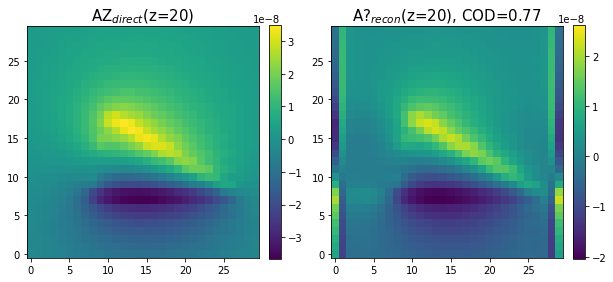

In [185]:
f,axs=plt.subplots(ncols=2,figsize=(10,5))
n=50
i=20
im=axs[0].imshow(AZ[:,:,i+n][n:-n,n:-n].T,origin='lower',vmin=np.min(AZ),vmax=np.max(AZ))
f.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)
axs[0].set_title('AZ$_{direct}$(z=%i)'%(i),fontsize=15)

azn= calculate_AZ_from_phase_recon(ry,mesh_params)
# '3D phase' projected and slice - reconstructed
im=axs[1].imshow(azn[:,:,i].T,origin='lower',vmin=np.min(azn),vmax=np.max(azn))
f.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)
cod = ma.COD(AZ[:,:,i+n][n:-n,n:-n],azn[:,:,i])
axs[1].set_title('A?$_{recon}$(z=%i), COD=%.2f'%(i,cod),fontsize=15)

cod = ma.COD(AZ[:,:,i+n][n:-n,n:-n],azn[:,:,i])

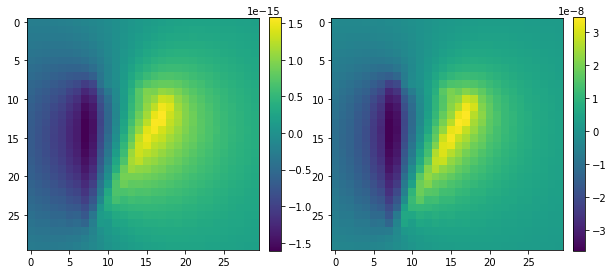

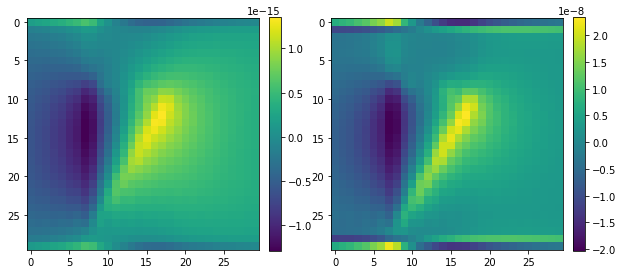

0.71932777169195361

In [84]:
# AZ projected and slice - directly calculated
f,axs=plt.subplots(ncols=2,figsize=(10,5))
n=50
im=axs[0].imshow(ma.project_along_z(AZ[n:-n,n:-n,n:-n],mesh_params=mesh_params))
f.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)
                 
im=axs[1].imshow(AZ[:,:,20+n][n:-n,n:-n])
f.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)
plt.show()

azn= calculate_AZ_from_phase_recon(ry,mesh_params)

# '3D phase' projected and slice - reconstructed
f,axs=plt.subplots(ncols=2,figsize=(10,5))
im=axs[0].imshow(ma.project_along_z(azn,mesh_params=mesh_params))
f.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)
im=axs[1].imshow(azn[:,:,20])
f.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)
plt.show()

ma.COD(AZ[n:-n,n:-n,n:-n],azn)

In [153]:
def calculate_B_dual(PX,PY,mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x_size = p2[0]
    x_res = x_size/n[0]
    
    y_size = p2[1]
    y_res = y_size/n[1]
    
    BX,BY,BZ = [],[],[]
    
    resx = p2[0]/n[0] # resolution in m per px 
    resy = p2[1]/n[1] # resolution in m per px 
    resz = p2[2]/n[2] # resolution in m per px 
    
    for i in range(np.shape(PX)[2]):
        px = PX[:,:,i]
        py = PY[:,:,i]
        d_phase_x = np.gradient(px,resx)
        d_phase_y = np.gradient(py,resy)
#         plt.imshow(d_phase_y[1])
#         plt.show()
        b_const = (constants.codata.value('mag. flux quantum')/(np.pi))
        b_field_x = -b_const*d_phase_y[1] / resx 
        b_field_y = b_const*d_phase_x[0] / resy 
        b_field_z = -1*(np.gradient(b_field_x,resz)[0]+np.gradient(b_field_y,resz)[1])*resz
        
        BX.append(b_field_x)
        BY.append(b_field_y)
        BZ.append(b_field_z)
        
    # somehow the axes are in the wrong order and this fixes it
    BX = np.transpose(BX,axes=[1,2,0])
    BY = np.transpose(BY,axes=[1,2,0])
    BZ = np.transpose(BZ,axes=[1,2,0])
    
    return np.array(BX),np.array(BY),np.array(BZ)

In [97]:
mesh_params

[(0, 0, 0),
 (1.0000000000000001e-07, 1.0000000000000001e-07, 1.0000000000000001e-07),
 (30, 30, 30)]

In [154]:
bx,by,bz = calculate_B_dual(rx,ry,mesh_params=mesh_params)

In [155]:
bxproj, byproj = ma.project_along_z(bx,mesh_params=mesh_params),ma.project_along_z(by,mesh_params=mesh_params)

In [159]:
ma.COD(bz,BZ[n:-n,n:-n,n:-n])

0.0014018665209470584

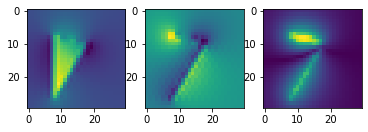

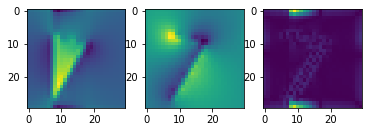

In [129]:
# B directly from A at the start
f,axs=plt.subplots(ncols=3)
axs[0].imshow(np.sum(BX[n:-n,n:-n,n:-n],axis=2))
axs[1].imshow(np.sum(BY[n:-n,n:-n,n:-n],axis=2))
axs[2].imshow(np.sum(abs(BZ[n:-n,n:-n,n:-n]),axis=2))

# reconstructed B
f,axs=plt.subplots(ncols=3)
axs[0].imshow(np.sum(bx,axis=2))
axs[1].imshow(np.sum(by,axis=2))
axs[2].imshow(abs(np.sum(bz,axis=2)))

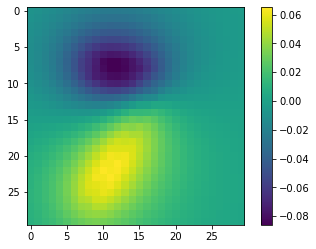

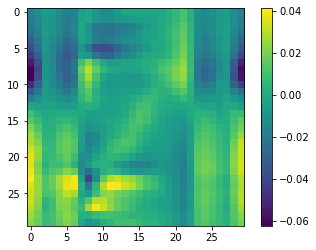

In [189]:
plt.imshow(BZ[n:-n,n:-n,n+27])
plt.colorbar()
plt.show()
plt.imshow(bz[:,:,27])#,vmin=-.5e-8,vmax=.5e-8)
plt.colorbar()

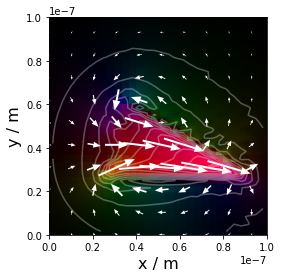

In [107]:
ma.plot_2d_B(np.sum(BX,axis=2)[n:-n,n:-n],np.sum(BY,axis=2)[n:-n,n:-n],mesh_params=mesh_params,scale=4,s=3)

In [106]:
bxp = ma.project_along_z(BX[n:-n,n:-n,n:-n],mesh_params=mesh_params)
np.max(bxp),np.max(bxproj)

(3.0405949643909915e-08, 2.3824935e-08)

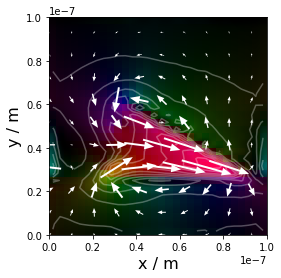

In [105]:
ma.plot_2d_B(bxproj,byproj,mesh_params=mesh_params,scale=4,s=3,quiver=True)

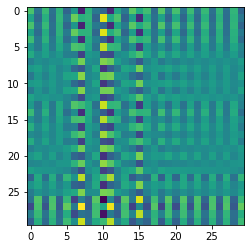

In [216]:
p1,p2,n=mesh_params
resx = p2[0]/n[0] # resolution in m per px 
resy = p2[1]/n[1] # resolution in m per px 
resz = p2[2]/n[2] # resolution in m per px 

kx = np.fft.fftfreq(bx.shape[0],d=resx)
ky = np.fft.fftfreq(bx.shape[0],d=resy)
kz = np.fft.fftfreq(bx.shape[0],d=resz)
KX, KY, KZ = np.meshgrid(kx,ky,kz, indexing='ij') # Create a grid of coordinates

KZ_inv = np.nan_to_num(((KZ+0.001*resx))**-1)
inside=-KX*KZ_inv*np.fft.fftn(bx)-KY*KZ_inv*np.fft.fftn(by)
#inside=np.fft.fftshift(inside)
bzn = np.fft.ifftn(inside).real

plt.imshow(bzn[:,:,28])

Phantom error:  0.4082152794619212 COD:  0.918625886734


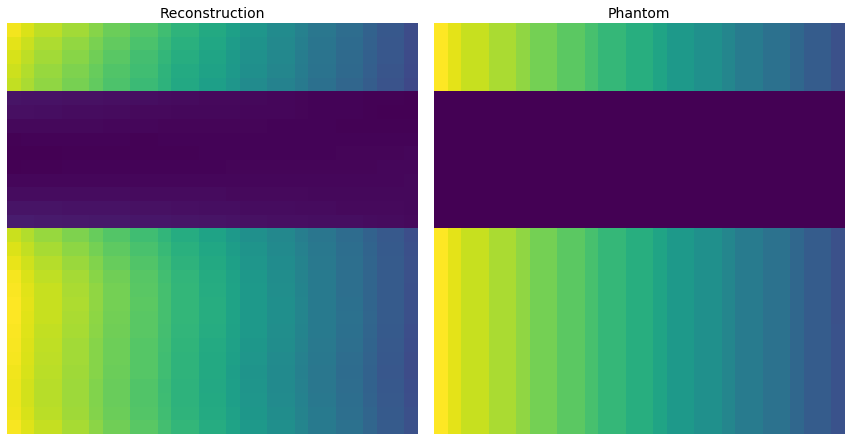

In [33]:
X,Y,Z,P = ma.generate_tri_pris(n=30)
angles = ma.generate_angles(mode='x',alpha=90,beta=90,tilt2='beta',n_tilt=13)
raw_data = ma.generate_proj_data(P,angles)
vectors = ma.generate_vectors(angles)
recon = ma.generate_reconstruction(raw_data,vectors,algorithm='SIRT3D_CUDA',niter=10,callback_freq=20,weight=0.001)
recon_vector = ma.reorient_reconstruction(recon)
ma.compare_projection(recon_vector,P,ax=90)

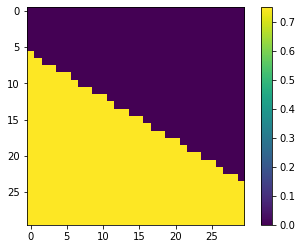

In [35]:
plt.imshow(raw_data[:,6,:])
plt.colorbar()

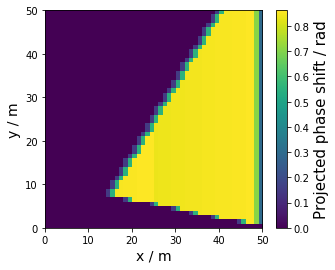

In [198]:
ma.plot_phase_proj(raw_data[:,20,:])

In [61]:
import time
angles = ma.generate_angles(mode='dual',alpha=90,beta=90,tilt2='beta',n_tilt=20)
phase_projs=[]
for i in range(len(angles)):
    ax,ay,az = angles[i]
    #rotate M
    MXr,MYr,MZr = rotate_magnetisation(MX,MY,MZ,ax,ay,az)
    #calculate phase
    phase = ma.calculate_phase_M_2D(MXr,MYr,MZr,mesh_params=mesh_params,n_pad=100)
    phase = np.flipud(phase.T)

    phase_projs.append(phase)            
    t3=time.time()
#    # Prepare projections for reconstruction
#    raw_data = np.array(M_projs)
#     raw_data = raw_data -  raw_data.min()
#     raw_data = raw_data/raw_data.max()
phase_projs = np.transpose(phase_projs,axes=[1,0,2]) # reshape so proj is middle column

phases = np.array(phase_projs)

0 31.08475685119629
1 31.407667875289917
2 31.612377882003784
3 31.8185977935791
4 32.14201831817627
5 32.34918141365051
6 32.55544137954712
7 32.76077127456665
8 33.085033893585205
9 33.29205131530762
10 33.49941110610962
11 33.70336174964905
12 33.909350872039795
13 34.231544733047485
14 34.43427515029907
15 34.64347529411316
16 34.85301685333252
17 35.1736364364624
18 35.38010287284851
19 35.58466172218323


In [68]:
p = phases-np.min(phases)
p=p/np.max(p)
vecs = ma.generate_vectors(angles)
recon = ma.generate_reconstruction(p,vecs, algorithm = 'SIRT3D_CUDA', niter=40, weight = 0.001,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

r = np.transpose(recon,axes=(2,1,0))[:,::-1,:]

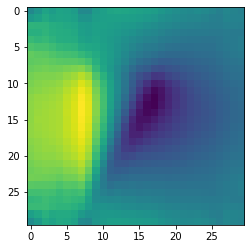

In [72]:
plt.imshow(np.sum(r[:,:,15])